# K-Medias

## Set up

In [142]:
#!pip install edastatmil_milser
!pip install --upgrade edastatmil_milser
color = "#254025"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

Defaulting to user installation because normal site-packages is not writeable


## Paso 1: Carga del conjunto de datos

In [128]:
from edastatmil_milser import edas_tatmil as EDA

total_data_raw = EDA.pd.read_csv('../data/raw/housing.csv', delimiter=',')
_ = EDA.explore(total_data_raw)


Rows: 20640
Columns: 9
+-------------+----------------+------------+-----------+---------------+
|             | Non-Null Count | Null Count | Data Type | Data Category |
+-------------+----------------+------------+-----------+---------------+
|   MedInc    |     20640      |     0      |  float64  |   Numerical   |
|  HouseAge   |     20640      |     0      |  float64  |   Numerical   |
|  AveRooms   |     20640      |     0      |  float64  |   Numerical   |
|  AveBedrms  |     20640      |     0      |  float64  |   Numerical   |
| Population  |     20640      |     0      |  float64  |   Numerical   |
|  AveOccup   |     20640      |     0      |  float64  |   Numerical   |
|  Latitude   |     20640      |     0      |  float64  |   Numerical   |
|  Longitude  |     20640      |     0      |  float64  |   Numerical   |
| MedHouseVal |     20640      |     0      |  float64  |   Numerical   |
+-------------+----------------+------------+-----------+---------------+


In [129]:
total_data_clean = total_data_raw[["Latitude", "Longitude", "MedInc"]]


In [130]:
train_data, test_data = train_test_split(total_data_clean, test_size=0.2, random_state=42)
train_data.to_csv(r'..\data\processed\SplitData\train_data.csv')
test_data.to_csv(r'..\data\processed\SplitData\test_data.csv')

## Paso 2: Construye un K-Means


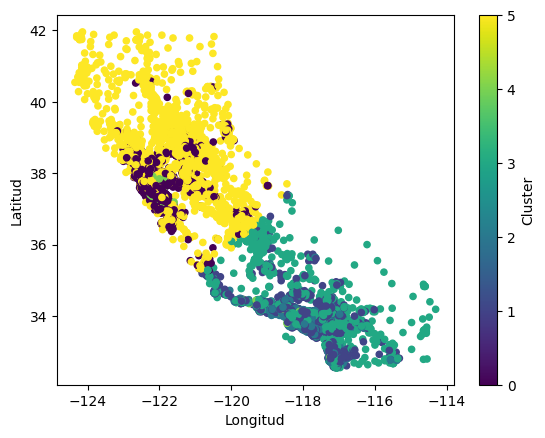

In [131]:
# Instanciar el modelo K-Means con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
kmeans.fit(train_data)

# Predecir los clusters para los datos de entrenamiento y de prueba
train_clusters = kmeans.predict(train_data)

# Agregar una nueva columna al DataFrame original con el número de cluster al que pertenece cada casa
train_data.loc[:, 'cluster'] = train_clusters

# Graficar los datos en un diagrama de puntos para visualizar los clusters
plt.scatter(train_data['Longitude'], train_data['Latitude'], c=train_data['cluster'], cmap='viridis', s=20)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Cluster')
plt.show()


In [132]:
train_data.to_csv(r'..\data\processed\train_data.csv')

## Paso 3: Predice con el conjunto de test


In [133]:
# Predecir los clusters para los datos de prueba
test_clusters = kmeans.predict(test_data)

# Agregar una nueva columna al DataFrame de prueba con el número de cluster al que pertenece cada casa
test_data.loc[:, 'cluster'] = test_clusters

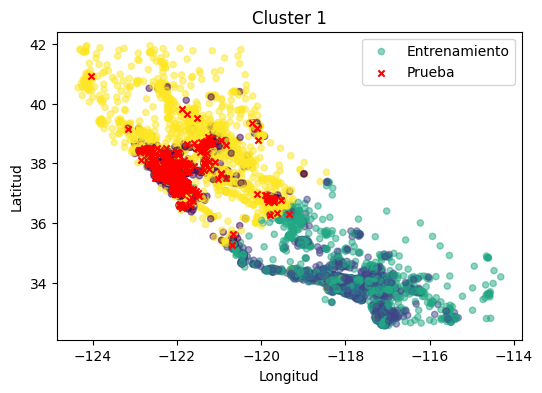

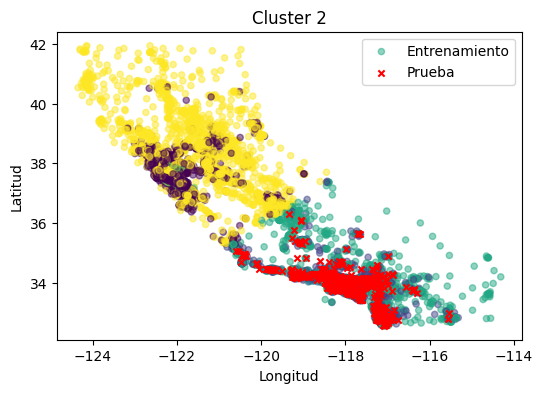

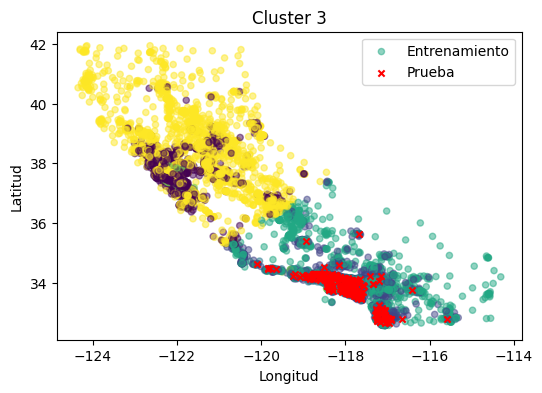

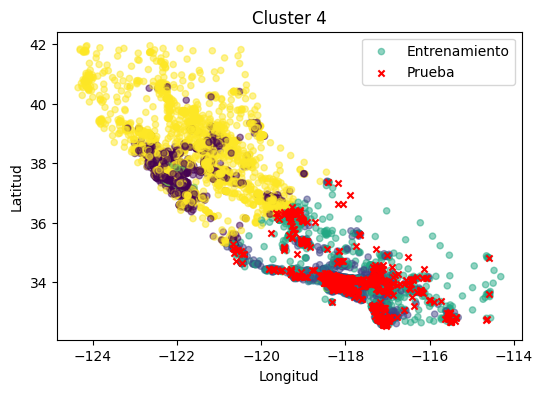

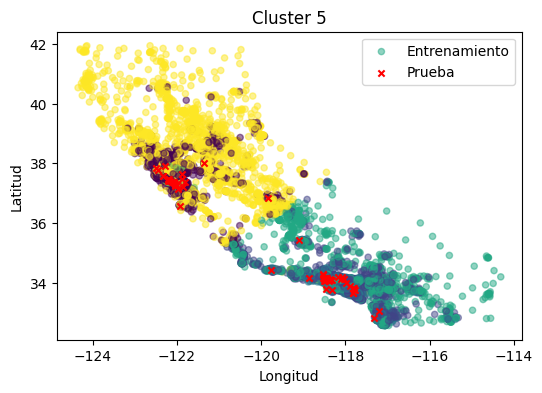

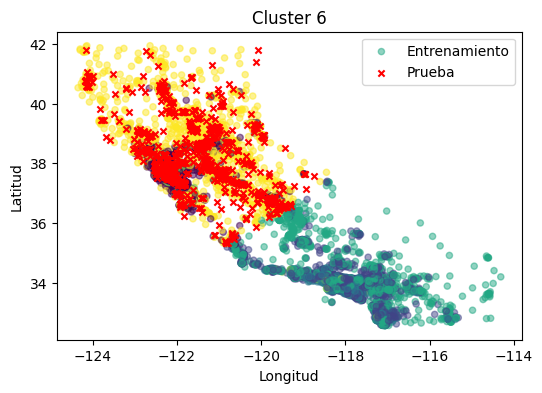

In [134]:
# Obtener los índices de las filas en el conjunto de prueba para cada cluster
test_cluster_indices = [test_data[test_data['cluster'] == i].index for i in range(6)]
# Graficar los clusters uno por uno
for i, indices in enumerate(test_cluster_indices):
    plt.figure(figsize=(6, 4))
    # Graficar los puntos de entrenamiento en cada iteración del bucle
    plt.scatter(train_data['Longitude'], train_data['Latitude'], c=train_data['cluster'], cmap='viridis', s=20, alpha=0.5, label='Entrenamiento')
    plt.scatter(test_data.loc[indices, 'Longitude'], test_data.loc[indices, 'Latitude'], c='red', s=20, marker='x', label='Prueba')
    plt.title(f'Cluster {i+1}')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend()
    plt.show()


## Paso 4: Entrena un modelo de clasificación supervisada

In [135]:
test_data.head(2)

,Latitude,Longitude,MedInc,cluster
20046,36.06,-119.01,1.6812,3
3024,35.14,-119.46,2.5313,3


### Lineal Regresion

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Definir la variable objetivo
target = 'cluster'

# Crear un modelo de regresión lineal
linear_regression = LinearRegression()

# Entrenar el modelo utilizando los datos de entrenamiento y las etiquetas de cluster
linear_regression.fit(train_data.drop(columns=[target]), train_data[target])

# Predecir los clusters para los datos de prueba
predicted_clusters_linear = linear_regression.predict(test_data.drop(columns=[target]))

# Convertir las predicciones a enteros (ya que los clusters son valores enteros)
predicted_clusters_linear = predicted_clusters_linear.astype(int)

# Calcular el error cuadrático medio (MSE)
mse_linear = mean_squared_error(test_data[target], predicted_clusters_linear)

# Imprimir el MSE
print("Mean Squared Error (MSE) - Regresión Lineal:", mse_linear)


Mean Squared Error (MSE) - Regresión Lineal: 2.3001453488372094


Era prebisible que la regresion lineal no iba a ser buena para este tipo de modelos, puesto que tenemos un modelo de clasificacion de 6 clusters.

Se desvia 1.5 de un valor, por lo que teniendo 6 clusters es una barbaridad. 

### Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir la variable objetivo
target = 'cluster'

# Crear un clasificador de Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Entrenar el clasificador utilizando las características y las etiquetas de cluster de los datos de entrenamiento
features_train = train_data.drop(columns=[target])  # Seleccionar características de entrenamiento
labels_train = train_data[target]  # Seleccionar etiquetas de entrenamiento
random_forest.fit(features_train, labels_train)  # Entrenar el modelo

# Predecir los clusters para los datos de prueba
features_test = test_data.drop(columns=[target])  # Seleccionar características de prueba
predicted_clusters_rf = random_forest.predict(features_test)  # Predecir los clusters

# Calcular la precisión
accuracy_rf = accuracy_score(test_data[target], predicted_clusters_rf)

# Imprimir la precisión
print("Accuracy - Random Forest:", accuracy_rf)


Accuracy - Random Forest: 0.9956395348837209


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir los valores de los hiperparámetros
n_estimators_values = [10, 50, 100, 200, 500]
max_depth_values = [None, 10, 20, 30, 50]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]
max_features_values = [1,2,3]
bootstrap_values = [True, False]

# Crear una matriz para almacenar las precisión de los modelos
accuracy_matrix_rf = np.zeros((len(n_estimators_values), len(max_depth_values), len(min_samples_split_values), len(min_samples_leaf_values), len(max_features_values), len(bootstrap_values)))

# Iterar sobre los valores de los hiperparámetros y entrenar los modelos
for i, n_estimators in enumerate(n_estimators_values):
    for j, max_depth in enumerate(max_depth_values):
        for k, min_samples_split in enumerate(min_samples_split_values):
            for l, min_samples_leaf in enumerate(min_samples_leaf_values):
                for m, max_features in enumerate(max_features_values):
                    for n, bootstrap in enumerate(bootstrap_values):
                        random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, random_state=42,n_jobs=-1)        
                        random_forest.fit(features_train, labels_train)
                        random_forest_pred = random_forest.predict(features_test)  
                        accuracy = accuracy_score(test_data[target], random_forest_pred)
                        accuracy_matrix_rf[i, j, k, l, m, n] = accuracy

# Visualizar la precisión de los modelos
plt.figure(figsize=(20, 8))
for i, n_estimators in enumerate(n_estimators_values):
    for j, max_depth in enumerate(max_depth_values):
        for k, min_samples_split in enumerate(min_samples_split_values):
            for l, min_samples_leaf in enumerate(min_samples_leaf_values):
                for m, max_features in enumerate(max_features_values):
                    for n, bootstrap in enumerate(bootstrap_values):
                        plt.plot(n_estimators, accuracy_matrix_rf[i, j, k, l, m, n], label=f"n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, max_features={max_features}, bootstrap={bootstrap}")

plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest Models with Different Hyperparameters')
plt.grid(True)
plt.legend()
plt.show()


KeyboardInterrupt: 

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Definir los valores de los hiperparámetros
n_estimators_values = [10, 50, 100, 200, 500]
max_depth_values = [None, 10, 20, 30, 50]
learning_rate_values = [0.01, 0.1, 0.3]
subsample_values = [0.5, 0.75, 1.0]
colsample_bytree_values = [0.5, 0.75, 1.0]

# Crear una matriz para almacenar las precisión de los modelos
accuracy_matrix_xgb = np.zeros((len(n_estimators_values), len(max_depth_values), len(learning_rate_values), len(subsample_values), len(colsample_bytree_values)))

# Iterar sobre los valores de los hiperparámetros y entrenar los modelos
for i, n_estimators in enumerate(n_estimators_values):
    for j, max_depth in enumerate(max_depth_values):
        for k, learning_rate in enumerate(learning_rate_values):
            for l, subsample in enumerate(subsample_values):
                for m, colsample_bytree in enumerate(colsample_bytree_values):
                    params = {
                        'objective': 'multi:softmax',
                        'num_class': len(np.unique(labels_train)),
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree,
                        'tree_method': 'hist',
                        'device': 'cuda',
                        'random_state': 42
                    }   
                    xgb_classifier = xgb.XGBClassifier(**params)
                    xgb_classifier.fit(features_train, labels_train)
                    xgb_pred = xgb_classifier.predict(features_test)
                    accuracy = accuracy_score(test_data[target], xgb_pred)
                    accuracy_matrix_xgb[i, j, k, l, m] = accuracy

# Visualizar la precisión de los modelos
plt.figure(figsize=(20, 8))
for i, n_estimators in enumerate(n_estimators_values):
    for j, max_depth in enumerate(max_depth_values):
        for k, learning_rate in enumerate(learning_rate_values):
            for l, subsample in enumerate(subsample_values):
                for m, colsample_bytree in enumerate(colsample_bytree_values):
                    plt.plot(n_estimators, accuracy_matrix_xgb[i, j, k, l, m], label=f"n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}")

plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy of XGBoost Models with Different Hyperparameters')
plt.grid(True)
plt.legend()
plt.show()


KeyboardInterrupt: 